In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
auth = pd.read_csv('auth_data.csv', sep = ';')
reg = pd.read_csv('reg_data.csv', sep = ';')

In [3]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [4]:
auth.isnull().sum()

auth_ts    0
uid        0
dtype: int64

In [5]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
reg.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
auth['auth_t'] = pd.to_datetime(auth['auth_ts'], unit='s')

In [8]:
reg['reg_t'] = pd.to_datetime(reg['reg_ts'], unit='s')

In [9]:
user = reg.merge(auth, on = 'uid', how = 'inner', suffixes = ('_reg', '_auth'))

In [10]:
user = user[['uid', 'reg_t', 'auth_t']]

In [11]:
user['day_since_reg'] = (user['auth_t'] - user['reg_t']).dt.days

In [12]:
user.groupby('uid')['day_since_reg'].max()

uid
1             0
2          7728
3             0
4             0
5             0
           ... 
1110618       0
1110619       0
1110620       0
1110621       0
1110622       0
Name: day_since_reg, Length: 1000000, dtype: int64

In [13]:
user

,uid,reg_t,auth_t,day_since_reg
0,1,1998-11-18 09:43:43,1998-11-18 09:43:43,0
1,2,1999-07-22 22:38:09,1999-07-22 22:38:09,0
2,2,1999-07-22 22:38:09,1999-07-25 16:46:46,2
3,2,1999-07-22 22:38:09,1999-07-31 03:50:15,8
4,2,1999-07-22 22:38:09,1999-08-05 17:49:39,13
...,...,...,...,...
9601008,1110618,2020-09-23 15:13:54,2020-09-23 15:13:54,0
9601009,1110619,2020-09-23 15:14:46,2020-09-23 15:14:46,0
9601010,1110620,2020-09-23 15:15:39,2020-09-23 15:15:39,0
9601011,1110621,2020-09-23 15:16:31,2020-09-23 15:16:31,0


In [14]:
user['retention_1'] = user['day_since_reg'] == 1
user['retention_7'] = user['day_since_reg'].isin([6, 7, 8])
user['retention_14'] = user['day_since_reg'].isin([12,13, 14, 15, 16])
user['retention_30'] = user['day_since_reg'].isin(np.arange(25,36,1))

In [15]:
user

,uid,reg_t,auth_t,day_since_reg,retention_1,retention_7,retention_14,retention_30
0,1,1998-11-18 09:43:43,1998-11-18 09:43:43,0,False,False,False,False
1,2,1999-07-22 22:38:09,1999-07-22 22:38:09,0,False,False,False,False
2,2,1999-07-22 22:38:09,1999-07-25 16:46:46,2,False,False,False,False
3,2,1999-07-22 22:38:09,1999-07-31 03:50:15,8,False,True,False,False
4,2,1999-07-22 22:38:09,1999-08-05 17:49:39,13,False,False,True,False
...,...,...,...,...,...,...,...,...
9601008,1110618,2020-09-23 15:13:54,2020-09-23 15:13:54,0,False,False,False,False
9601009,1110619,2020-09-23 15:14:46,2020-09-23 15:14:46,0,False,False,False,False
9601010,1110620,2020-09-23 15:15:39,2020-09-23 15:15:39,0,False,False,False,False
9601011,1110621,2020-09-23 15:16:31,2020-09-23 15:16:31,0,False,False,False,False


In [16]:
retention = user.groupby('uid')[['retention_1', 'retention_7', 'retention_14', 'retention_30']].max().reset_index()

In [17]:
retention

,uid,retention_1,retention_7,retention_14,retention_30
0,1,False,False,False,False
1,2,False,True,True,True
2,3,False,False,False,False
3,4,False,False,False,False
4,5,False,False,False,False
...,...,...,...,...,...
999995,1110618,False,False,False,False
999996,1110619,False,False,False,False
999997,1110620,False,False,False,False
999998,1110621,False,False,False,False


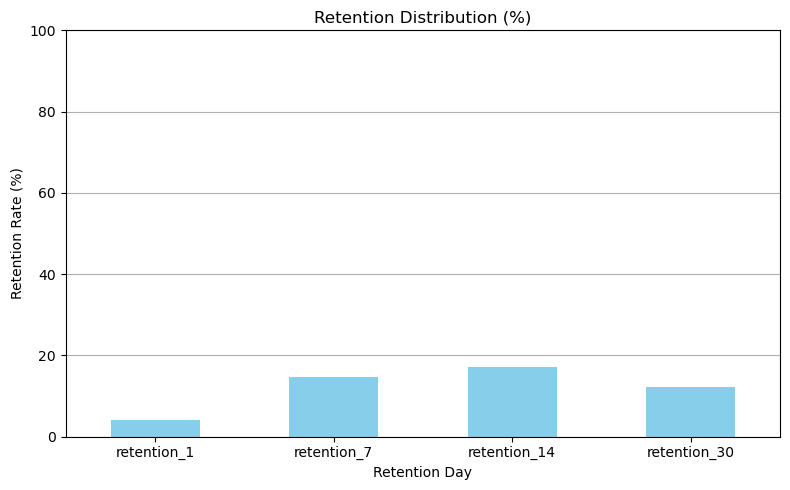

In [18]:
# Select only the retention columns
retention_cols = [col for col in retention.columns if col.startswith('retention_')]

# Calculate retention rates (mean of True values per column)
retention_rates = retention[retention_cols].mean() * 100

# Plot
plt.figure(figsize=(8, 5))
retention_rates.plot(kind='bar', color='skyblue')
plt.title('Retention Distribution (%)')
plt.ylabel('Retention Rate (%)')
plt.xlabel('Retention Day')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [19]:
retention = retention.merge(reg, on = 'uid', how = 'inner')

In [20]:
retention

,uid,retention_1,retention_7,retention_14,retention_30,reg_ts,reg_t
0,1,False,False,False,False,911382223,1998-11-18 09:43:43
1,2,False,True,True,True,932683089,1999-07-22 22:38:09
2,3,False,False,False,False,947802447,2000-01-13 22:27:27
3,4,False,False,False,False,959523541,2000-05-28 14:19:01
4,5,False,False,False,False,969103313,2000-09-16 11:21:53
...,...,...,...,...,...,...,...
999995,1110618,False,False,False,False,1600874034,2020-09-23 15:13:54
999996,1110619,False,False,False,False,1600874086,2020-09-23 15:14:46
999997,1110620,False,False,False,False,1600874139,2020-09-23 15:15:39
999998,1110621,False,False,False,False,1600874191,2020-09-23 15:16:31


In [21]:
retention['reg_t'] = pd.to_datetime(retention['reg_t'])

retention['reg_year'] = retention['reg_t'].dt.year

retention_by_year = retention.groupby('reg_year')[['retention_1', 'retention_7', 'retention_14', 'retention_30']].mean() * 100

print(retention_by_year)

          retention_1  retention_7  retention_14  retention_30
reg_year                                                      
1998         0.000000     0.000000      0.000000      0.000000
1999         0.000000   100.000000    100.000000    100.000000
2000         0.000000     0.000000      0.000000      0.000000
2001         0.000000     0.000000      0.000000      0.000000
2002         0.000000    20.000000     30.000000     10.000000
2003         5.000000    15.000000     20.000000     10.000000
2004         2.857143    17.142857     17.142857     17.142857
2005         1.538462    15.384615     16.923077     10.769231
2006         3.361345    14.285714     16.806723     11.764706
2007         4.166667    12.962963     18.981481     11.111111
2008         3.045685    14.720812     16.497462     11.421320
2009         4.596100    15.041783     17.270195     12.395543
2010         3.363914    15.137615     17.737003     13.379205
2011         4.192872    13.417191     17.064990     12